# INTRODUCTION

## Overview

Natural Language Processing is a complex field which is hypothesised to be part of AI-complete set of problems, implying that the difficulty of these computational problems is equivalent to that of solving the central artificial intelligence problem of making computers as intelligent as people. With over 90% of data ever generated being produced in the last 2 years and with a great proportion being human generated unstructured text there is an ever increasing need to advance the field of Natural Language Processing.

Recent UK Government proposal to have measures to regulate social media companies over harmful content, including "substantial" fines and the ability to block services that do not stick to the rules is an example of the regulamentary need to better manage the content that is being generated by users.

Other initiatives like ​Riot Games​' work aimed to predict and reform toxic player behaviour during games is another example of this effort to understand the content being generated by users and moderate toxic content.
However, as highlighted by the Kaggle competition ​Jigsaw unintended bias in toxicity classification​, existing models suffer from unintended bias where models might predict high likelihood of toxicity for content containing certain words (e.g. "gay") even when those comments were not actually toxic (such as "I am a gay woman"), leaving machine only classification models still sub-standard.

The outcome of our analysis is the type of algorithm that companies will use to define what is free speech and what shouldn't be tolerated in a discussion. This challenge actually starts with how the training dataset was produced: Multiple people (annotators) read thousands of comments and defined if those comments were offensive or not. Where is the trick? They disagreed in many of them. Having tools that are able to flag up toxic content without suffering from unintended bias is of paramount importance to preserve Internet's fairness and freedom of speech

## Dataset

At the end of 2017 the Civil Comments platform shut down and chose make their ~2m public comments from their platform available in a lasting open archive so that researchers could understand and improve civility in online conversations for years to come. Jigsaw sponsored this effort and extended annotation of this data by human raters for various toxic conversational attributes.

In the data supplied for this competition, the text of the individual comment is found in the comment_text column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity for the Test data. This attribute (and all others) are fractional values which represent the fraction of human raters who believed the attribute applied to the given comment.

For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).


In [25]:
import warnings
warnings.filterwarnings('ignore')



In [26]:
from __future__ import print_function

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
import missingno as msno


import numpy as np
import pandas as pd
from scipy import stats
import spacy
from sklearn.decomposition import PCA

from wordcloud import WordCloud ,STOPWORDS

import watermark

from tqdm import tqdm_notebook

from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim import corpora, models
from sklearn.model_selection import train_test_split
import operator
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
#lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
nltk.download('wordnet')

%load_ext watermark

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix


PROJ_ROOT = os.path.join(os.pardir)

print(os.path.abspath(PROJ_ROOT))

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
C:\Users\Parth\Documents\Parth\Data science\Springboard\github\Springboard\capstone projects


### Important Library Version Information

In [27]:
%watermark -a "Parth Patel" -d -t -v -p  numpy,pandas  --iversions

watermark  1.8.1
seaborn    0.9.0
scipy      1.2.1
plotly     3.9.0
missingno  0.4.1
gensim     3.4.0
nltk       3.4
numpy      1.16.2
re         2.2.1
spacy      2.1.4
pandas     0.24.2
matplotlib 3.0.3
Parth Patel 2019-06-18 20:02:22 

CPython 3.6.8
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2


In [28]:
train_df = pd.read_csv('Data/train.csv')

### Data Set Overview
#### Load the data

In [29]:
len(train_df)

1804874

#### Shape of the Data

In [30]:
print('Shape of data: ', train_df.shape)

Shape of data:  (1804874, 45)


The provided data consists of over 1804k observations of movies along with 30 column variables. Let us take a look into what each column looks like.

#### First Few Observations

In [31]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [32]:
train_df.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


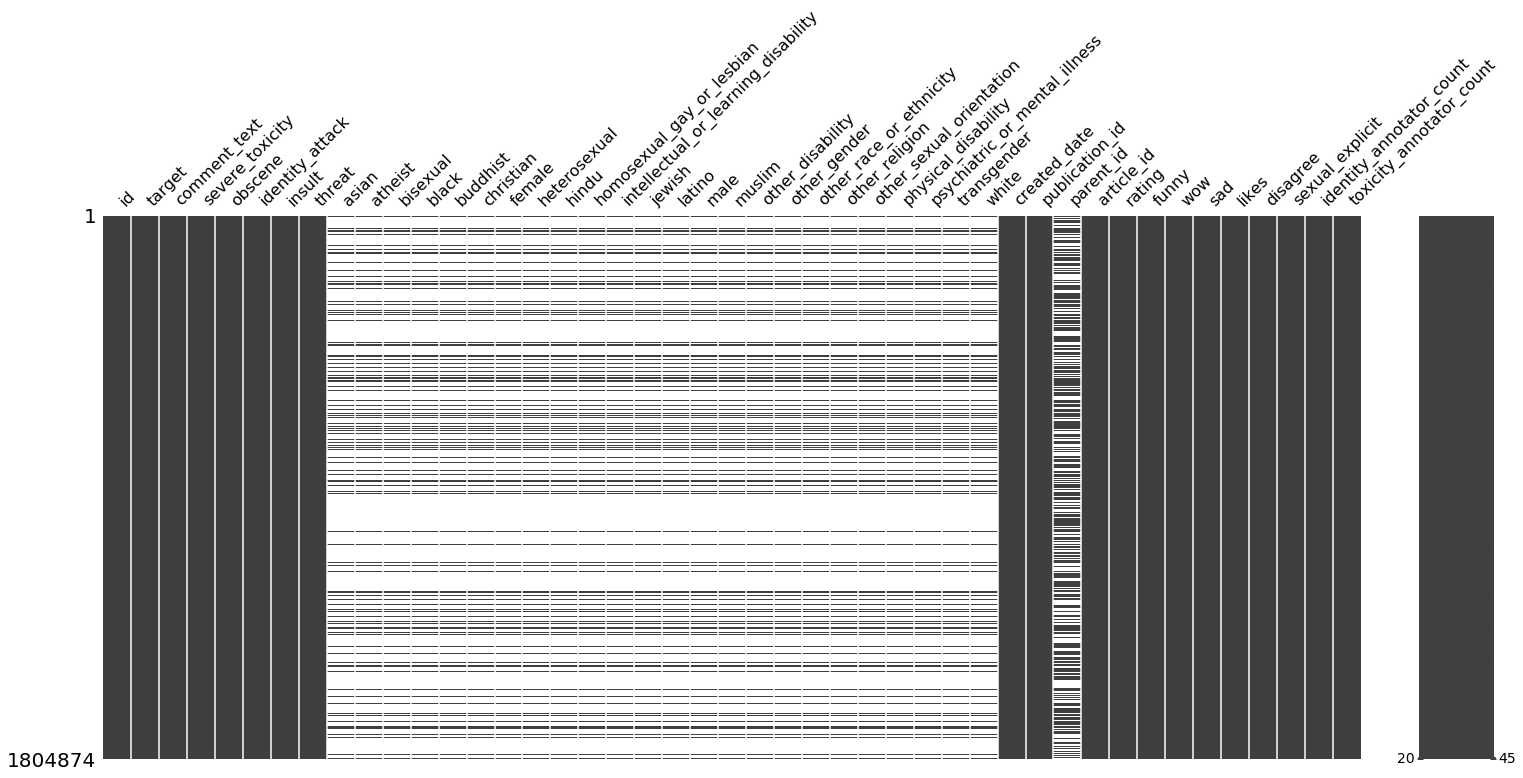

In [33]:
msno.matrix(train_df)

#### Obersvation
* most of the featurs describing imformation regarding people are missing
* other filled data like funny , wow , sad are usually zero

### EDA

#### Target feature
Let's check the distribution of target value in the train set.


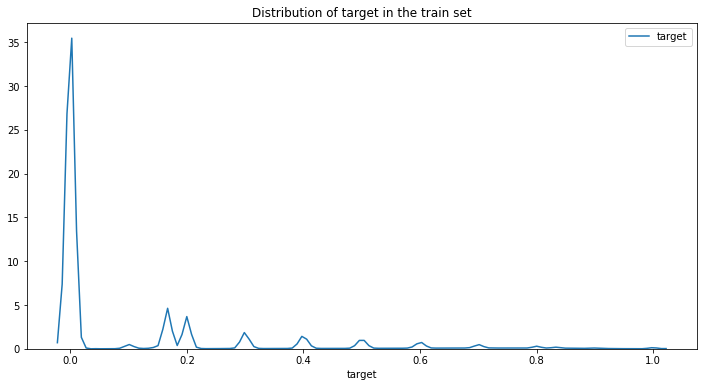

In [34]:
plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(train_df['target'],kde=True,hist=False, bins=120, label='target')
plt.legend(); plt.show()

#### Observation:
* many of the colum are non toxic

#### Lets See how features are distributed

In [35]:
def plot_features_distribution(features, title):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(train_df[feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

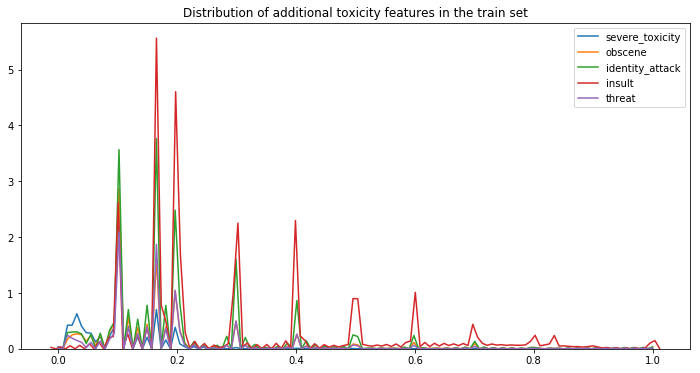

In [36]:
features = ['severe_toxicity', 'obscene','identity_attack','insult','threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set")

* All toxicity subtype are similarly distibuted

#### Sensitive topics features
* Let's check now the distribution of sensitive topics features values.

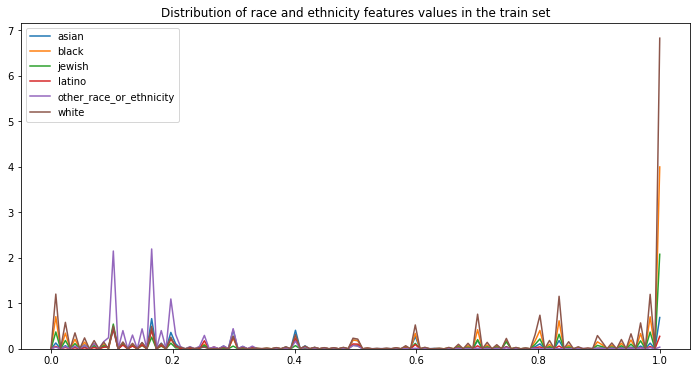

In [37]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set")

#### Observations:
* White and Black dominate Toxic comments
* other race people are usually less toxic

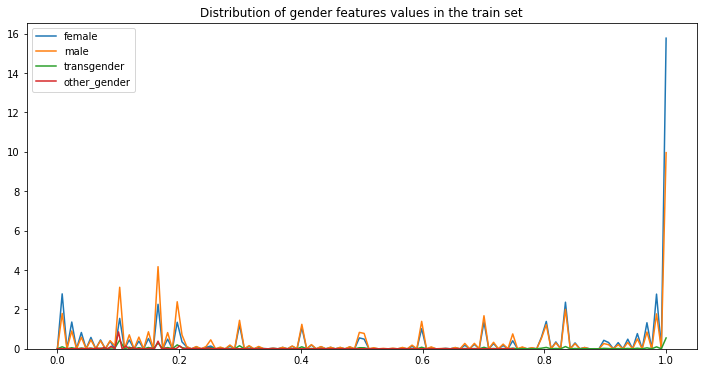

In [38]:
features = ['female', 'male', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender features values in the train set")

#### Observations:
* Comments mentioning female are usually high toxic

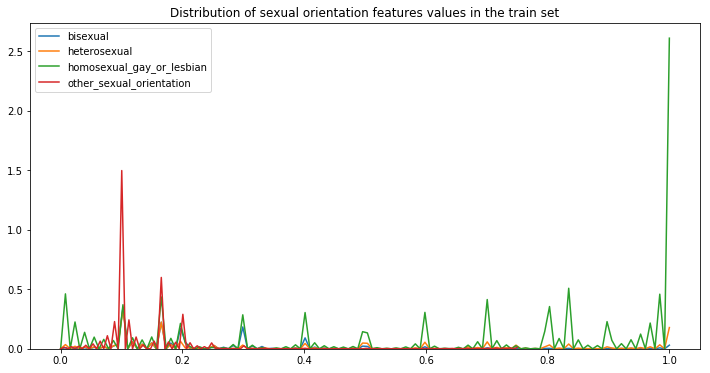

In [39]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set")

#### Observations:
* Comments towards homosexual are usually high toxic

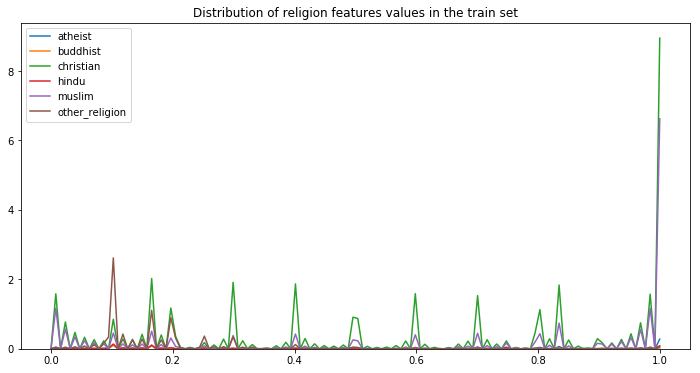

In [40]:
features = ['atheist','buddhist',  'christian', 'hindu', 'muslim', 'other_religion']
plot_features_distribution(features, "Distribution of religion features values in the train set")

#### Observations:
* Comments with christian and muslim are usually high toxic

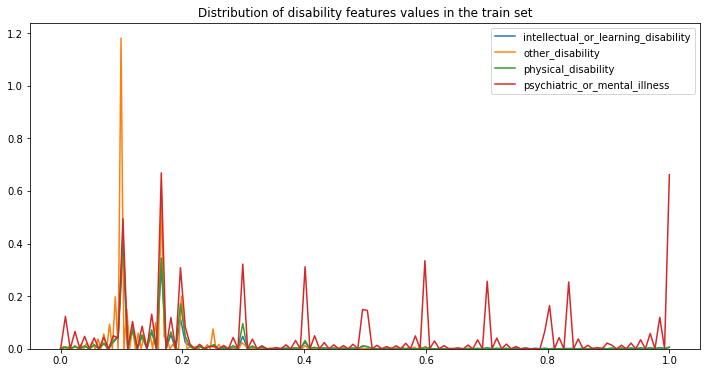

In [41]:
features = ['intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
plot_features_distribution(features, "Distribution of disability features values in the train set")

#### Observations:
* Comments towards mentally disabled people are usually tageted

### Word Cloud Plots

Let's show the prevalent words in the train set (we will use a 20,000 comments sample and show top 50 words).


In [42]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

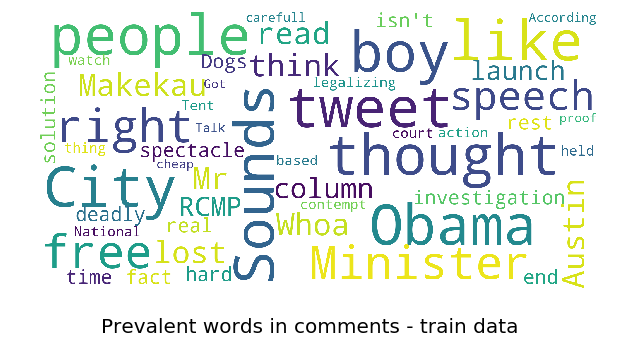

In [43]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

Let's show now the frequent used words in comments for which insult score under 0.25 and above 0.75.

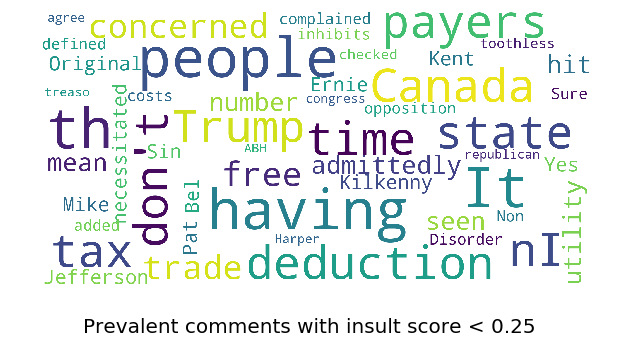

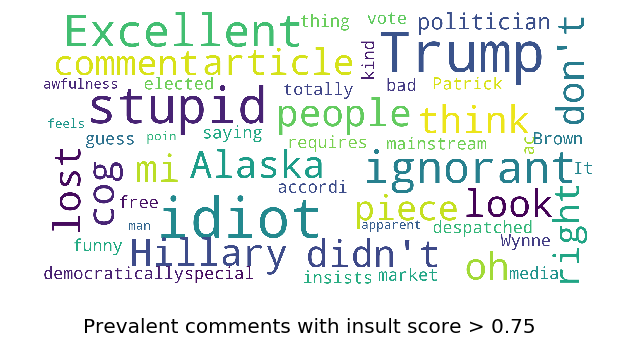

In [44]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

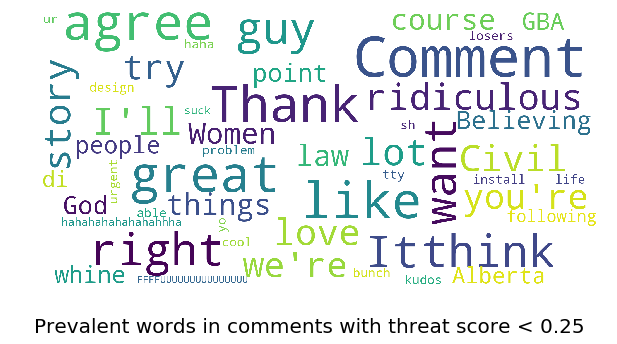

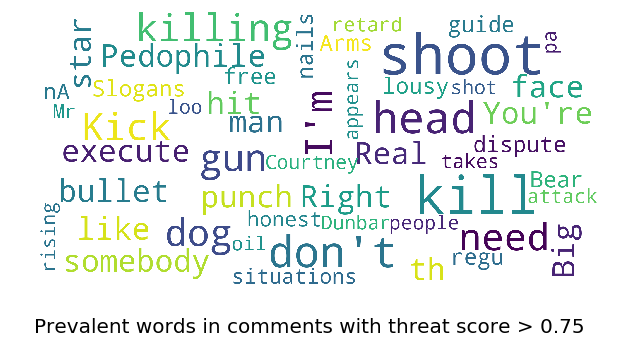

In [45]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

#### Let's show the wordcloud of frequent words used in comments with obscene score < 0.25 and obscene score > 0.75.


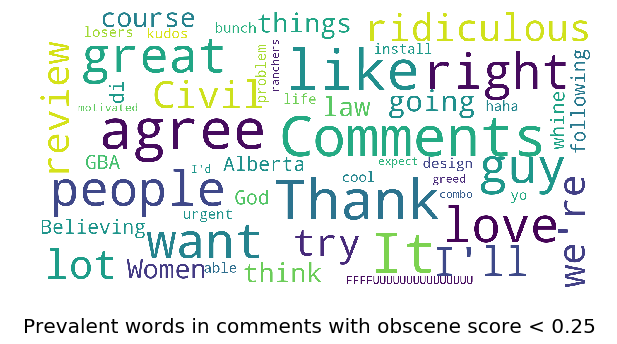

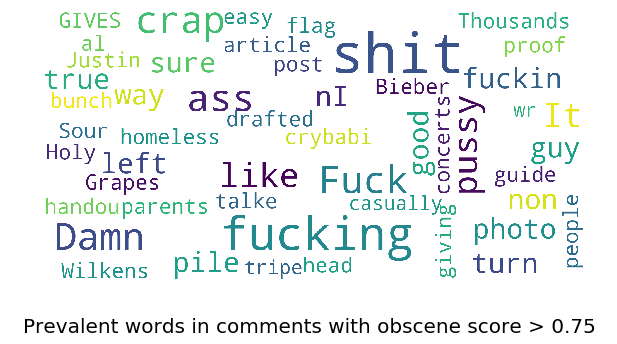

In [46]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

#### Let's show now the prevalent words in comments with target (toxicity) score under 0.25 and over 0.75.



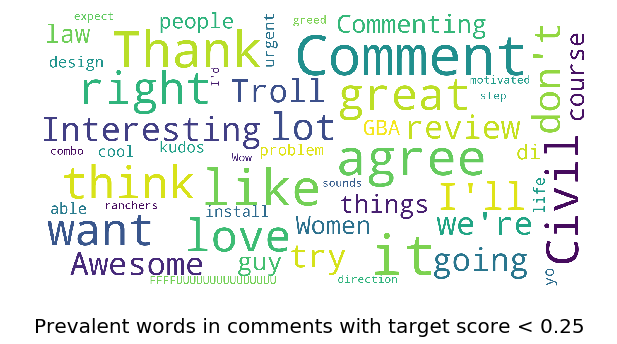

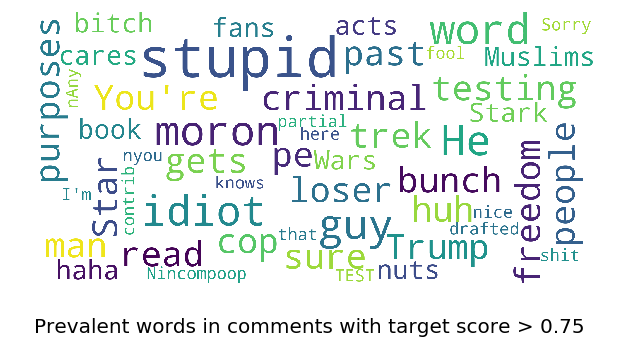

In [47]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

#### Observatios:
* there are certain words which can be not toxic or very toxic like Trump
* we have certain words which are clearly very abusive refering to sexual topics
* there are some clear non toxic words refering good vibration like love , civil etc.


#### Feature Engineering
Since our main independat column is commets lets try to create features out of it

In [48]:
train_df['total_length'] = train_df['comment_text'].apply(len)
train_df['capitals'] = train_df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train_df['caps_vs_length'] = train_df.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
train_df['num_exclamation_marks'] = train_df['comment_text'].apply(lambda comment: comment.count('!'))
train_df['num_question_marks'] = train_df['comment_text'].apply(lambda comment: comment.count('?'))
train_df['num_punctuation'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train_df['num_symbols'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
train_df['num_words'] = train_df['comment_text'].apply(lambda comment: len(comment.split()))
train_df['num_unique_words'] = train_df['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
train_df['words_vs_unique'] = train_df['num_unique_words'] / train_df['num_words']
train_df['num_smilies'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))


In [49]:
train_df['Is_toxic'] =  train_df['target'].apply(lambda x: "Toxic" if x>=0.5 else "NonToxic")

In [50]:
features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique', 'num_smilies', 'num_symbols','target')

#### Lets see distubtion of comment data from features created

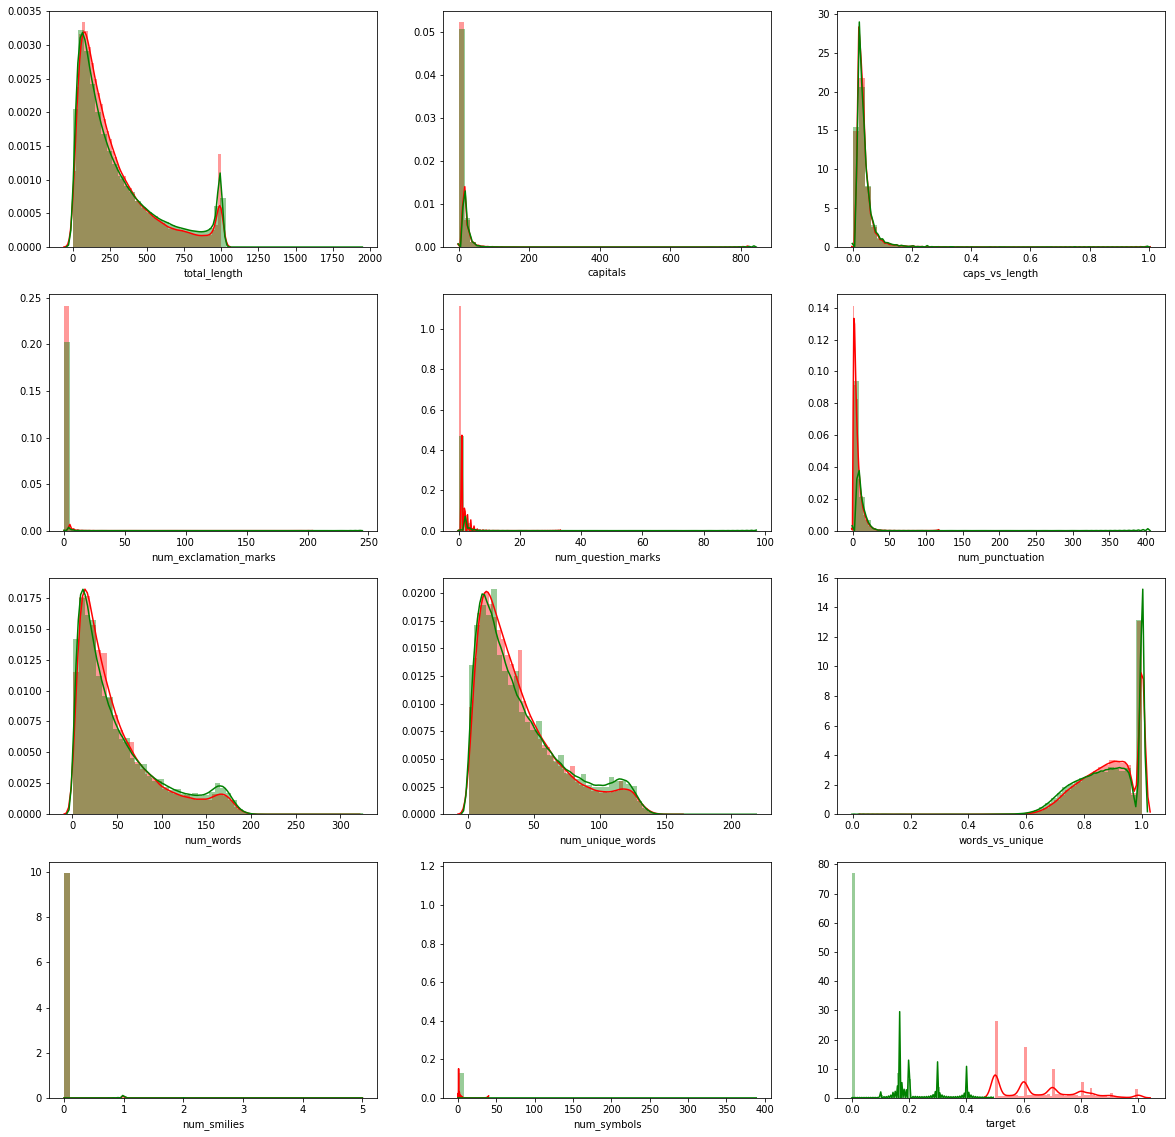

In [51]:
row = 4
col = 3
fig, ax = plt.subplots(row,col)  
fig.set_figheight(row*5)          
fig.set_figwidth(20)               
#df[df['B']==3]['A']
n = 0
for i in range(0,row):
    for j in range(0,col):
        sns.distplot(train_df[train_df['Is_toxic']=="Toxic"][features[n]], ax=ax[i][j],color='r') 
        n += 1
n = 0
for i in range(0,row):
    for j in range(0,col):
        sns.distplot(train_df[train_df['Is_toxic']=="NonToxic"][features[n]], ax=ax[i][j],color='g') 
        n += 1

#### Observations:

* Similar distribution for word and character level (just the way English is)
* A peak at character length = 1000, and minimal data with length > 1000.
* This is probably due to different character truncation selection during the data collection. Note that there are still some comments with length > 1000. Perhaps we should take special note of the truncated comments? The toxic may not occure before the truncation

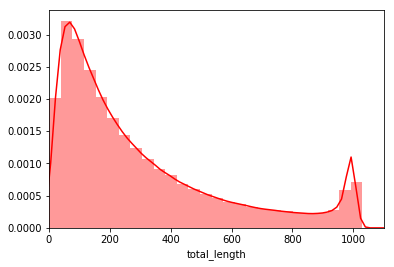

In [52]:
sns.distplot(train_df['total_length'] , color='r')
plt.xlim(0, 1100)
plt.show()

Here, we seem to have a bimodal distribution of character length in the data. Although the lengths seem to be heavily skewed to the lower lengths, we see another clear peak around the 1000 character mark.



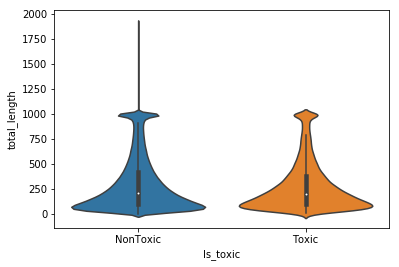

In [53]:
sns.violinplot(x=train_df['Is_toxic'], y=train_df['total_length']);

Text(0.5, 1.0, 'Toxic vs Non Toxic Comments')

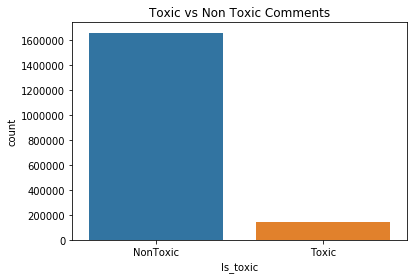

In [54]:
sns.countplot(train_df['Is_toxic'])
plt.title('Toxic vs Non Toxic Comments')

#### observation :
* most of the comments we have are Non-Toxic , thus distribution is imbalance

#### Lets try to understand Co-Relation betwenn Variable

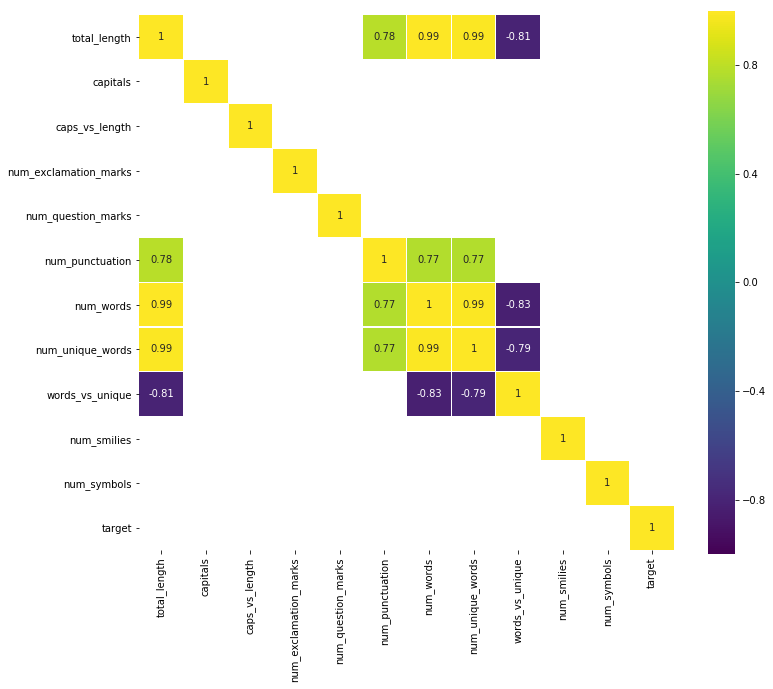

In [55]:
numf = train_df.filter(features, axis=1)
corr = numf.corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.6) | (corr <= -0.6)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True);

#### Observation:
* non of new feature have high co-relation with target
* no of words and no of unique words are very highly corelated
* we do have positive corelation with number of puncuation and number of words


### OBSERVATION AND ASSUMPTION 

* Based on Above analysis all newly created column and existing supporting column does not have co-relation with target 
* There is very uneven distribution of toxic and non-toxic comments 
* creating word or sentence vector on above dataset will be very time consuming on current machine 
* non-toxic comments will be filtered out to create 30-70 ratio of toxic and non-toxic comments, concerning available resource and prioritising importance of understanding and implementation of NLP Concept

In [56]:
Nontoxic_df = train_df.loc[train_df['Is_toxic'] == 'NonToxic']
Nontoxic_df = Nontoxic_df.head(481113)

toxic_df = train_df.loc[train_df['Is_toxic'] == 'Toxic']

In [57]:
#del final_df
final_df = pd.concat([Nontoxic_df,toxic_df])
#Nontoxic_df.append(toxic_df) 
len(final_df)

625447

In [58]:
final_df['Is_toxic'].value_counts()

NonToxic    481113
Toxic       144334
Name: Is_toxic, dtype: int64

Text(0.5, 1.0, 'Toxic vs Non Toxic Comments')

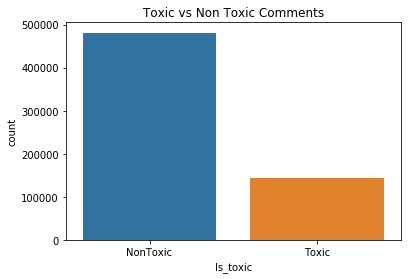

In [59]:
sns.countplot(final_df['Is_toxic'])
plt.title('Toxic vs Non Toxic Comments')

In [60]:
#dir()
del Nontoxic_df
del toxic_df
del train_df

In [61]:
final_df.id.nunique()

625447

In [62]:
final_df = final_df[['id','comment_text','target']]

In [63]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625447 entries, 0 to 1804872
Data columns (total 3 columns):
id              625447 non-null int64
comment_text    625447 non-null object
target          625447 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 39.1+ MB


### Text Data Clening

Text cleaning will be performed mainly in 5 steps, which will be 
* Lower caseing
* Expanding Contractions
* Removing Special Characters
* Removing Stopwords

#### Lower Case
Here all alphabet will be converted to lower case as all avaible mapping are in lower case alphabet as well as it will remove inconsistant typing errors and make standard text words and sentence.

#### Removing Special Characters
Special characters and symbols are usually non-alphanumeric characters or even occasionally numeric characters (depending on the problem), which add to the extra noise in unstructured text. Usually, simple regular expressions (regexes) can be used to remove them.

#### Removing Stopwords
Words which have little or no significance, especially when constructing meaningful features from text, are known as stopwords or stop words. These are usually words that end up having the maximum frequency if you do a simple term or word frequency in a corpus. Typically, these can be articles, conjunctions, prepositions and so on. Some examples of stopwords are a, an, the, and the like.

#### Lemmatization
Lemmatization is very similar to stemming, where we remove word affixes to get to the base form of a word. However, the base form in this case is known as the root word, but not the root stem. The difference being that the root word is always a lexicographically correct word (present in the dictionary), but the root stem may not be so. Thus, root word, also known as the lemma, will always be present in the dictionary. Both nltk and spacy have excellent lemmatizers. We will be using spacy here.

#### Expanding Contractions
Contractions are shortened version of words or syllables. They often exist in either written or spoken forms in the English language. These shortened versions or contractions of words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. Examples would be, do not to don’t and I would to I’d. Converting each contraction to its expanded, original form helps with text standardization.


In [64]:
def clean_contractions(text, mapping):
    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}


In [66]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # lemmatizing words in dcoument
    filtered_tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)


In [67]:
final_df['comment_text'] = normalize_corpus(final_df['comment_text'])

In [68]:
final_df['comment_text'] = final_df['comment_text'].apply(lambda x: clean_contractions(x, contraction_mapping))